<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/01wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

{{<video https://youtu.be/playlist?list=PLQqh36zP38-x6P7VsPJG0cqNkbJTII5yR&si=HhIbz4gH711kw7Dx >}}

# 2. Imports

In [2]:
import torch
import matplotlib.pyplot as plt 

# 3. 로드맵

`-` 회귀분석 $\to$ 로지스틱 $\to$ 심층신경망(DNN) $\to$ 합성곱신경망(CNN)

# 4. 파이썬 문법 복습을 위한 참고자료 

`-` 넘파이 문법이 약하다면? (reshape, concatenate, stack, row/col vector)

1. [reshape](https://guebin.github.io/IP2022/2022/04/06/(6%EC%A3%BC%EC%B0%A8)-4%EC%9B%946%EC%9D%BC.html): 넘파이공부 2단계 reshape 참고
2. [concatenate,stack](https://guebin.github.io/IP2022/2022/04/11/(6%EC%A3%BC%EC%B0%A8)-4%EC%9B%9411%EC%9D%BC.html): 아래 링크의 넘파이공부 4단계 참고
3. [col-vec,row-vec](https://guebin.github.io/STBDA2022/2022/03/14/(2주차)-3월14일.html): 3x1 col-vec 선언방법, 1x3 row-vec 선언방법에서 `[[1],[2],[3]]` 혹은 `[[1,2,3]]` 와 같은 표현이 이해안되면 링크의 첫번째 동영상 12:15 - 22:45 에 해당하는 분량을 학습할 것.

# 5. 회귀모형

## A. 모형소개

`-` model:
$y_i= w_0+w_1 x_i +\epsilon_i = 2.5 + 4x_i +\epsilon_i, \quad i=1,2,\dots,n$

`-` model: ${\bf y}={\bf X}{\bf W} +\boldsymbol{\epsilon}$

-   ${\bf y}=\begin{bmatrix} y_1 \\ y_2 \\ \dots \\ y_n\end{bmatrix}, \quad {\bf X}=\begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \dots \\ 1 & x_n\end{bmatrix}, \quad {\bf W}=\begin{bmatrix} 2.5 \\ 4 \end{bmatrix}, \quad \boldsymbol{\epsilon}= \begin{bmatrix} \epsilon_1 \\ \dots \\ \epsilon_n\end{bmatrix}$

## B. 회귀모형에서 데이터 생성

In [3]:
torch.manual_seed(43052)
ones= torch.ones(100).reshape(-1,1) # 100x1
x,_ = torch.randn(100).sort()           # 평균 0, 분산1인 정규 분포에서 sort 하여 크기순으로 나열
x = x.reshape(-1,1) # 100x1
X = torch.concat([ones,x],axis=-1)  # 100x2
W = torch.tensor([[2.5],[4]])       # 2x1
ϵ = torch.randn(100).reshape(-1,1)*0.5  # 평균 0, 분산1인 정규 분포에 0.5만큼 scaling 함
y = X@W + ϵ                             # (100*2) x (2*1) = 100x1

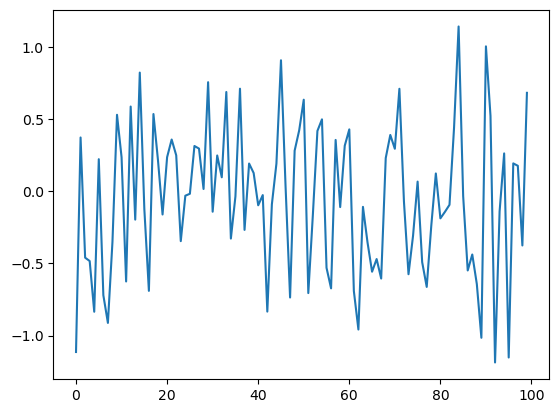

In [20]:
plt.plot(ϵ) # 노이즈 도식화

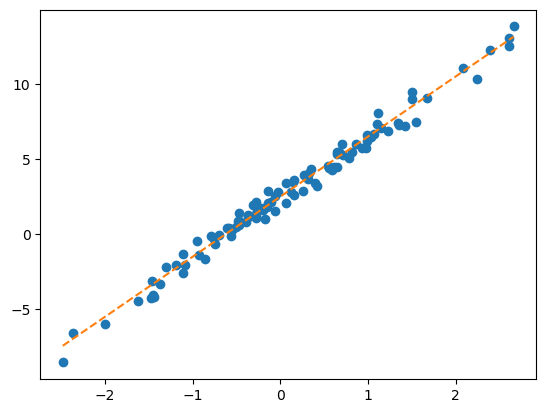

In [22]:
plt.plot(x,y,'o')               # Noise Measurement
plt.plot(x,2.5+4*x,'--')        # Ground Truth

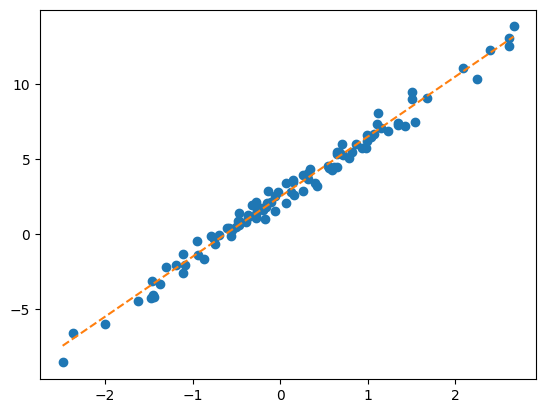

In [5]:
# plt.plot(x,y,'o')               # Noise Measurement
plt.plot(x,X@W+ϵ,'o')           # Noise Measurement
plt.plot(x,2.5+4*x,'--')        # Ground Truth

# 6. 회귀모형에서 학습이란?

`-` 파란점만 주어졌을때, 주황색 점선(기울기와 절편)을 추정하는것. 좀 더 정확하게 말하면
given data로 $\begin{bmatrix} \hat{w}_0 \\ \hat{w}_1 \end{bmatrix}$를
최대한 $\begin{bmatrix} 2.5 \\ 4 \end{bmatrix}$와 비슷하게 찾는것.

-   given data : $\big\{(x_i,y_i) \big\}_{i=1}^{n}$

-   parameter: ${\bf W}=\begin{bmatrix} w_0 \\ w_1 \end{bmatrix}$

-   estimated parameter:
    ${\bf \hat{W}}=\begin{bmatrix} \hat{w}_0 \\ \hat{w}_1 \end{bmatrix}$

`-` 더 쉽게 말하면 아래의 그림을 보고 `적당한` 추세선을 찾는것이다.

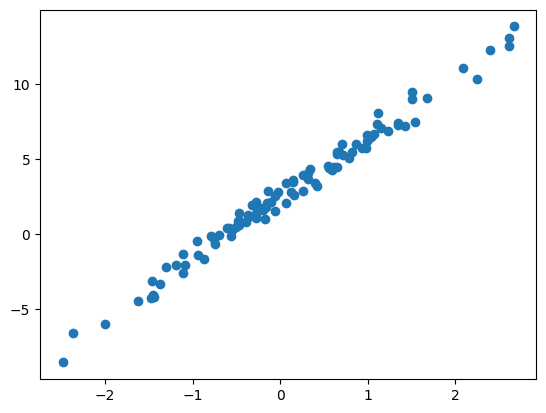

In [6]:
plt.plot(x,y,'o')   # Given data

`-` 시도: $(\hat{w}_0,\hat{w}_1)=(-5,10)$을 선택하여 선을 그려보고 적당한지 판단. --> "인간"지능을 활용하여 더 나은 선을 찾아보자. 

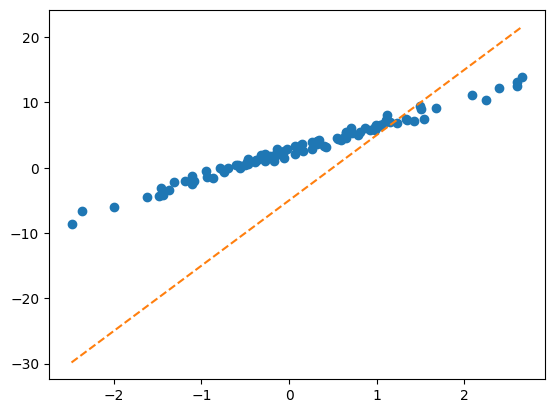

In [7]:
plt.plot(x,y,'o')            # Given data
plt.plot(x,-5+10*x,'--')     # Initial Estimation

`-` 벡터표현으로 주황색점선을 계산

In [11]:
What = torch.tensor([[-5.0],[10.0]])

In [12]:
print(What.grad)
print(What.shape)

None
torch.Size([2, 1])


In [13]:
X.shape

torch.Size([100, 2])

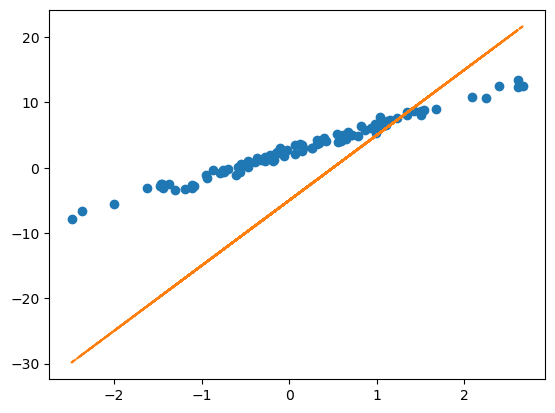

In [14]:
plt.plot(x,y,'o')
plt.plot(x,X@What,'--')

- 이건 일단 망한 학습같음.. 

# 7. 학습전략

`-` 이론적으로 추론 \<- 회귀분석시간에 배운것

`-` **컴퓨터의 반복계산을 이용하여 추론 (손실함수도입 + 경사하강법)**
\<- 우리가 오늘 파이토치로 실습해볼 내용.

`-` 전략: 아래와 같은 3단계 전략을 취한다.

-   1단계: 아무 점선이나 그어본다..
-   2단계: 1단계에서 그은 점선보다 더 좋은 점선으로 바꾼다.
-   3단계: 1-2단계를 반복한다.

# 8. `#1단계`실습 -- 최초의 직선 

> 1단계 = 아무 점선이나 그어보자..

`-` $\hat{w}_0=-5, \hat{w}_1 = 10$ 으로 설정하고 (왜? 그냥) 임의의 선을
그어보자.

In [32]:
What = torch.tensor([[-5.0],[10.0]],requires_grad=False)
What

tensor([[-5.],
        [10.]])

In [27]:
print(What.grad)

None


In [35]:
What = torch.tensor([[-5.0],[10.0]],requires_grad=True)
What

tensor([[-5.],
        [10.]], requires_grad=True)

tensor([[-5.],
        [10.]], requires_grad=True)
와 같은 기분나쁜 ? 꼬리표가 보인다. 추후 plot 할때 꼬리표를 제거해줘야 matplot이 된다

In [36]:
print(What.grad)

None


-   처음에는
    ${\bf \hat{W}}=\begin{bmatrix} \hat{w}_0 \\ \hat{w}_1 \end{bmatrix}=\begin{bmatrix} -5 \\ 10 \end{bmatrix}$
    를 대입해서 주황색 점선을 적당히 그려보자는 의미

-   끝에 requires_grad=True는 나중에 미분을 위한 것

In [37]:
yhat = X@What 

In [51]:
What = torch.tensor([[-5.0],[10.0]],requires_grad=False)
yhat = X@What 
print(What.grad)
print("-----------")
print(yhat.grad)
print(yhat) # grad_fn 꼬리표 없음

None
-----------
None
tensor([[-11.1034],
        [ -3.4793],
        [ 10.0310],
        [ -3.5801],
        [  2.8221],
        [ -7.7339],
        [ -6.8163],
        [-10.6210],
        [  1.4690],
        [ -8.6880],
        [ -6.4480],
        [ 21.0560],
        [  8.4936],
        [ -7.0004],
        [-19.6354],
        [ -1.7799],
        [-16.0918],
        [  0.4426],
        [  4.8037],
        [-12.4213],
        [-14.4690],
        [ -9.7097],
        [ -8.7195],
        [  6.0239],
        [-24.9730],
        [  1.1483],
        [-10.5064],
        [-28.6215],
        [-10.8296],
        [-19.5093],
        [ -3.4325],
        [-19.4352],
        [ -9.6756],
        [-13.6426],
        [  2.0592],
        [  1.5234],
        [ -3.8047],
        [  2.1414],
        [-12.5486],
        [ 10.4369],
        [-10.0578],
        [ -8.8736],
        [ 17.4440],
        [ -8.1592],
        [  6.5317],
        [-21.2394],
        [ 15.8323],
        [  0.5794],
        [  8.4032]

In [55]:
What = torch.tensor([[-5.0],[10.0]],requires_grad=True)
yhat = X@What 
print(What.grad)
print("-----------")
print(yhat.grad)
print(yhat) # grad_fn 꼬리표가 존재

None
-----------
None
tensor([[-11.1034],
        [ -3.4793],
        [ 10.0310],
        [ -3.5801],
        [  2.8221],
        [ -7.7339],
        [ -6.8163],
        [-10.6210],
        [  1.4690],
        [ -8.6880],
        [ -6.4480],
        [ 21.0560],
        [  8.4936],
        [ -7.0004],
        [-19.6354],
        [ -1.7799],
        [-16.0918],
        [  0.4426],
        [  4.8037],
        [-12.4213],
        [-14.4690],
        [ -9.7097],
        [ -8.7195],
        [  6.0239],
        [-24.9730],
        [  1.1483],
        [-10.5064],
        [-28.6215],
        [-10.8296],
        [-19.5093],
        [ -3.4325],
        [-19.4352],
        [ -9.6756],
        [-13.6426],
        [  2.0592],
        [  1.5234],
        [ -3.8047],
        [  2.1414],
        [-12.5486],
        [ 10.4369],
        [-10.0578],
        [ -8.8736],
        [ 17.4440],
        [ -8.1592],
        [  6.5317],
        [-21.2394],
        [ 15.8323],
        [  0.5794],
        [  8.4032]

/tmp/ipykernel_41158/1259988364.py:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538622298/work/build/aten/src/ATen/core/TensorBody.h:489.)
  print(yhat.grad)


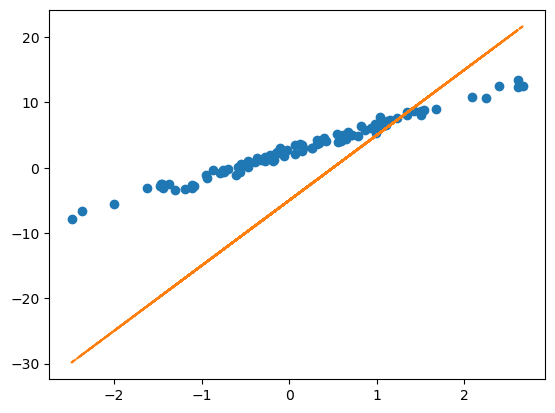

In [58]:
plt.plot(x,y,'o')
plt.plot(x,yhat.data,'--') # 그림을 그리기 위해서 yhat의 미분꼬리표를 제거

# 9. `#2단계`실습 -- 업데이트 (다음시간이어서..)

> 2단계 = 업데이트 = 최초의 점선에 대한 ‘적당한 정도’를 판단하고 더 ’적당한’ 점선으로 업데이트 한다.

## A. 손실함수

`-` ’적당한 정도’를 판단하기 위한 장치: loss function 도입!

$loss=\sum_{i=1}^{n}(y_i-\hat{y}_i)^2=\sum_{i=1}^{n}(y_i-(\hat{w}_0+\hat{w}_1x_i))^2$

$=({\bf y}-{\bf\hat{y}})^\top({\bf y}-{\bf\hat{y}})=({\bf y}-{\bf X}{\bf \hat{W}})^\top({\bf y}-{\bf X}{\bf \hat{W}})$

`-` loss 함수의 특징 

- $y_i \approx \hat{y}_i$ 일수록 loss값이 작다.
- $y_i \approx \hat{y}_i$ 이 되도록 $(\hat{w}_0,\hat{w}_1)$을 잘 찍으면
loss값이 작다.
- (중요) 주황색 점선이 ‘적당할 수록’ loss값이 작다.

In [59]:
loss = torch.sum((y-yhat)**2)
loss

tensor(8627.2363, grad_fn=<SumBackward0>)

In [62]:
X = torch.concat([ones,x],axis=-1)      # 100x2
What = torch.tensor([[-5.0],[10.0]])    # 초기값
yhat = X@What 

vec_loss = (torch.tensor((y-yhat))).T @ torch.tensor((y-yhat))
vec_loss

/tmp/ipykernel_41158/385358029.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vec_loss = (torch.tensor((y-yhat))).T @ torch.tensor((y-yhat))


tensor([[8627.2344]])

`-` 우리의 목표: 이 loss(=8587.6875)을 더 줄이자. 

- 궁극적으로는 아예 모든 조합 $(\hat{w}_0,\hat{w}_1)$에 대하여 가장 작은 loss를 찾으면 좋겠다. (단계2에서 할일은 아님)

`-` 문제의 치환: 생각해보니까 우리의 문제는 아래와 같이 수학적으로 단순화 되었다. 

- 적당해보이는 주황색 선을 찾자 $\to$ $loss(w_0,w_1)$를 최소로하는 $(w_0,w_1)$의 값을 찾자.

`-` 수정된 목표: $loss(w_0,w_1)$를 최소로 하는 $(w_0,w_1)$을 구하라. 

- 단순한 수학문제가 되었다. 이것은 마치 2변수 함수 $f(x,y)$를 최소화하는 $(x,y)$를 찾으라는 것임.
- 함수의 최대값 혹은 최소값을 컴퓨터를 이용하여 찾는것을 "최적화"라고 하며 이는 산공교수님들이 가장 잘하는 분야임. (산공교수님들에게 부탁하면 잘해줌, 산공교수님들은 보통 최적화해서 어디에 쓸지보다 최적화 자체에 더 관심을 가지고 연구하심)
- 최적화를 하는 방법? 경사하강법

## B. 경사하강법

`-` 경사하강법 아이디어 (1차원)

1. 임의의 점을 찍는다.
2. 그 점에서 순간기울기를 구한다. (접선) \<– 미분
3. 순간기울기(=미분계수)의 부호를 살펴보고 부호와 반대방향으로 움직인다.

> 팁: 기울기의 절대값 크기와 비례하여 보폭(=움직이는 정도)을 조절한다. $\to$ $\alpha$를 도입

> 최종수식: $w \leftarrow w - \alpha \times \frac{\partial}{\partial w}loss(w)$ 

`-` 경사하강법 아이디어 (2차원)

1. 임의의 점을 찍는다.
2. 그 점에서 순간기울기를 구한다. (접평면) \<– 편미분
3. 순간기울기(=미분계수)의 부호를 살펴보고 부호와 반대방향으로 각각 움직인다.

> 팁: 여기서도 기울기의 절대값 크기와 비례하여 보폭(=움직이는 정도)을 각각 조절한다. $\to$ $\alpha$를 도입.

`-` 경사하강법 = **loss를 줄이도록 ${\bf W}$를 개선하는 방법**

- 업데이트 공식: 수정값 = 원래값 - $\alpha$ $\times$ 기울어진크기(=미분계수)
- 여기에서 $\alpha$는 전체적인 보폭의 크기를 결정한다. 즉 $\alpha$값이 클수록 한번의 update에 움직이는 양이 크다.

# 10. HW 

없음